# Autoencoder POD Multiivariate Training Autoencoders and PCA (Expiriment 1)
 One Hour and One Day



------

In [1]:
pwd

'/root/eks-ml-pipeline/eks_ml_pipeline'

## Imports

In [2]:
!pip uninstall -y msspackages

Keyring is skipped due to an exception: 'keyring.backends'
Found existing installation: msspackages 0.0.7
Uninstalling msspackages-0.0.7:
  Successfully uninstalled msspackages-0.0.7


In [4]:
!pip install /root/msspackages/dist/msspackages-0.0.7-py3-none-any.whl

Keyring is skipped due to an exception: 'keyring.backends'
Processing /root/msspackages/dist/msspackages-0.0.7-py3-none-any.whl


In [5]:
from msspackages import setup_runner
setup_runner()

b"Hit:1 http://deb.debian.org/debian buster InRelease\nGet:2 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]\nHit:3 http://deb.debian.org/debian buster-updates InRelease\nFetched 34.8 kB in 0s (122 kB/s)\nReading package lists...\nBuilding dependency tree...\nReading state information...\n52 packages can be upgraded. Run 'apt list --upgradable' to see them.\nReading package lists...\nBuilding dependency tree...\nReading state information...\nsudo is already the newest version (1.8.27-1+deb10u4).\n0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\ndefault-jre is already the newest version (2:1.11-71).\n0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\npython3 is already the newest version (3.7.3-1).\n0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded

In [6]:
!python3 -m pip install -r requirements.txt

Keyring is skipped due to an exception: 'keyring.backends'


In [7]:
from msspackages import Pyspark_data_ingestion
from pyspark import StorageLevel
from pyspark.sql.functions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
sns.set(color_codes=True)
from numpy.random import seed
import tensorflow as tf



from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
#pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# %%time
# from msspackages import Pyspark_data_ingestion
# pod_obj = Pyspark_data_ingestion(year = '2022', month = '10', day = '10', hour = -1, filter_column_value ='Pod',setup='128gb')
# spark = pod_obj.get_spark()
# err, pod_data = pod_obj.read()
# pod_data = pod_data.select(*pod_data.columns,get_json_object(col("kubernetes"),"$.pod_id").alias("pod_id"))

# features_list =  ['Timestamp','pod_id','pod_status','pod_memory_utilization','pod_network_total_bytes','pod_cpu_utilization']
# pod_data = pod_data.select(features_list)

# pod_data.write.parquet("pod_data_one_day.parquet")


In [9]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
import keras
from keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from models import autoencoder_model_dish_5g

from sklearn.model_selection import train_test_split



In [10]:
pd.set_option('display.max_rows', None)

First lets read in our training sample set 

In [11]:
import pandas as pd

training_df_full = pd.read_parquet('pod_data_one_hour.parquet')

In [12]:
pod_df=training_df_full.query("pod_status == 'Running'")

In [13]:
# training_df_full = training_df_full.drop(training_df_full.columns.difference(columns_to_keep),1, inplace=False)
pod_df['Timestamp'] = pd.to_datetime(pod_df['Timestamp'], unit='ms')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
pod_df.head()

,Timestamp,pod_id,pod_status,pod_memory_utilization,pod_network_total_bytes,pod_cpu_utilization
0,2022-10-10 09:59:40.504,3ff8b4dd-aec7-4e4f-b66c-5b7b99821a7c,Running,0.040647,1.437919e+06,0.000790
1,2022-10-10 09:59:42.465,c57d2cce-e3e7-436e-99f2-bc23b7badea8,Running,0.273012,4.624508e+04,0.232224
2,2022-10-10 09:59:41.745,7500bb71-d4d1-4c03-84cf-a6683553b136,Running,0.121350,1.120958e+04,0.054349
3,2022-10-10 09:59:40.719,6731b8b8-5f10-4950-bd43-d1ce2c43a583,Running,0.265602,2.877183e+04,0.034304
4,2022-10-10 09:59:37.516,e2783813-09ad-420a-a34a-04c7b01f4791,Running,0.112260,1.035475e+04,0.044972


In [15]:
# pod_df.groupby('pod_id')['Timestamp'].count().hist()

In [16]:
pods_by_count = pod_df.groupby('pod_id')['Timestamp'].count() 
count_filter_1 = (pods_by_count >= 45)
count_filter_2 = (pods_by_count <= 75)

# get a list of pods with the right length 
ok_pod_list = pods_by_count[count_filter_1 & count_filter_2].index #.sample(1_000, replace=True).index

-----

In [17]:
## for normalization
scaler = StandardScaler()

In [18]:
import random 
features = ['pod_cpu_utilization','pod_memory_utilization','pod_network_total_bytes']

In [19]:
# training_df = 
ok_pod_filter = pod_df['pod_id'].isin(ok_pod_list)
training_df = pod_df[ ok_pod_filter ][['Timestamp'] + ['pod_id']+features]

In [20]:
%%time


def make_df_for_pod(pod):
    pod_filter = (training_df.pod_id == pod)
    return     training_df[ pod_filter ].sort_values(by='Timestamp').reset_index(drop=True)


    
pod_dfs = [ make_df_for_pod(pod) for pod in training_df['pod_id'].unique() ] 

CPU times: user 4min 47s, sys: 49.7 ms, total: 4min 47s
Wall time: 4min 47s


In [21]:
with open('pods_dfs_onehour.npy', 'wb') as f:
    np.save(f, pod_dfs)

/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [22]:
##global variable

time_steps = 20
batch_size = 32
n_samples = batch_size*1000 #000

In [23]:
%%time
#initializing for training set
x_train = np.zeros((n_samples,time_steps,len(features)))

for b in range(n_samples):
    ##pick random df, and normalize
    df = random.choice(pod_dfs)
    df = df.dropna()

    df = df.drop(columns = ['pod_id'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    
    ##make sure length of df is atleast 40
    if len(df) >= 40 :
        df = scaler.fit_transform(df[['pod_cpu_utilization','pod_memory_utilization','pod_network_total_bytes']])
        sample = np.zeros((n_samples,time_steps,len(features)))
        
        first_time = random.choice(range(len(df)-time_steps))
        sample = df[first_time:first_time+time_steps]
        x_train[b] = sample
  
    else:
        print('This never hapens')
        continue
        
# x_train[159,:,0]

CPU times: user 2min 29s, sys: 11.8 ms, total: 2min 29s
Wall time: 2min 29s


In [24]:
with open('train_20_32_1000onehour.npy', 'wb') as f:
    np.save(f, x_train)

# Training for 9485 Pods with the following parameters
time_steps = 20
batch_size = 32
n_samples = batch_size*1000 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              135168    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 20, 256)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          394240    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 20, 3)            771       
 ibuted)                                                         
                                                                 
Total params: 530,179
Trainable params: 530,179
Non-trai

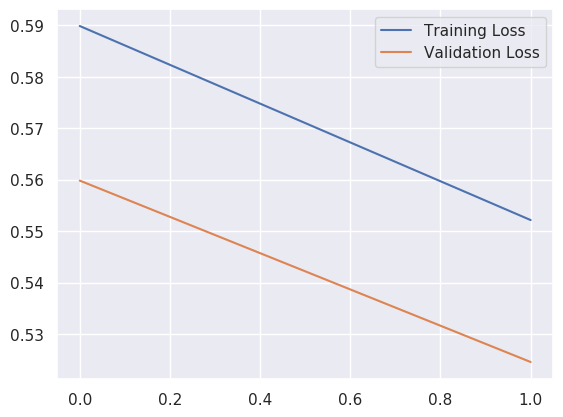

1000/1000 [==============================] - 11s 10ms/step


In [24]:
from models import autoencoder_model_dish_5g
model = autoencoder_model_dish_5g(batch_size = batch_size, 
                                  time_steps = time_steps,
                                  learning_rate=0.001,
                                  validation_split=.1, 
                                  epochs=100, 
                                  nuerons = 128, 
                                  dropout_rate=.1
                                 )
model.fit(x_train)

In [25]:
model.fraction_of_variance_lost(x_train)

1000/1000 [==============================] - 10s 10ms/step


[0.8280269900323836, 0.5541252117231082, 0.8711429083154767]

In [25]:
from sklearn.metrics import explained_variance_score
results, error = model.test(x_train[:,:,:])
scores = []

for i in range(3):
    scores.append(explained_variance_score(y_true = x_train[:,:,i], y_pred = results[:,:,i]))
# model.loss_of_varaiance(x_train,results)

scores

1000/1000 [==============================] - 11s 11ms/step


[0.987059160897523, 0.9871588350440342, 0.9853511112843538]

In [26]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=x_train.shape[1])
# train_set_predictions,_ = model.test(x_train)

# loss_of_variance = []

# for i in range(3):
#     pca.fit(x_train[:,:,i]).explained_variance_.sum()
#     variance_of_x_train = pca.fit(x_train[:,:,i]).explained_variance_.sum()
#     variance_of_DoEx_train = pca.fit( train_set_predictions[:,:,i] ).explained_variance_.sum()
#     loss_of_variance.append(variance_of_x_train - variance_of_DoEx_train)

# loss_of_variance

### train for 9485 PODS in one hour 
time_steps = 20
batch_size = 16
n_samples = batch_size*1000 #000

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              135168    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 20, 256)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          394240    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 20, 3)            771       
 ibuted)                                                         
                                                                 
Total params: 530,179
Trainable params: 530,179
Non-trai

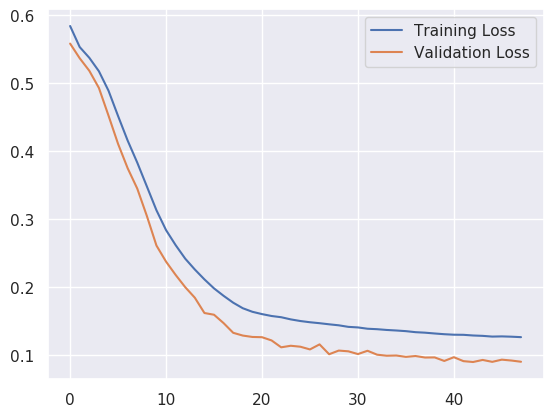

500/500 [==============================] - 6s 10ms/step


In [38]:
from models import autoencoder_model_dish_5g
model = autoencoder_model_dish_5g(batch_size = batch_size, 
                                  time_steps = time_steps,
                                  learning_rate=0.001,
                                  validation_split=.1, 
                                  epochs=100, 
                                  nuerons = 128, 
                                  dropout_rate=.1
                                 )
model.fit(x_train)

In [158]:
from sklearn.metrics import median_absolute_error

In [157]:
model.results.shape

(16000, 20, 3)

In [168]:
maes = 0
for i in range(3):
    maes += median_absolute_error(x_train[:,:,i], model.results[:,:,i])
    
mae_train_loss  = (maes)/3
mae_train_loss

0.0966878951664284

In [23]:
# model: i_model.IModel = autoencoder_model.AutoEncoderModel(batch_size = batch_size, time_steps = time_steps)

In [135]:
from models import pca_ad_dish_5g

In [140]:
x_train.shape

(16000, 20, 3)

In [143]:
pca = pca_ad_dish_5g.pca_ad_dish_5g(num_of_features =x_train.shape[2], 
                                    number_of_temporal_slices = 1, 
                                    timesteps_per_slice = x_train.shape[1], 
                                    n_modes_to_delete=1
                                   )

In [172]:
pca.vs[0].shape
last_right_principal_vector = pca.vs[0][:,-1]

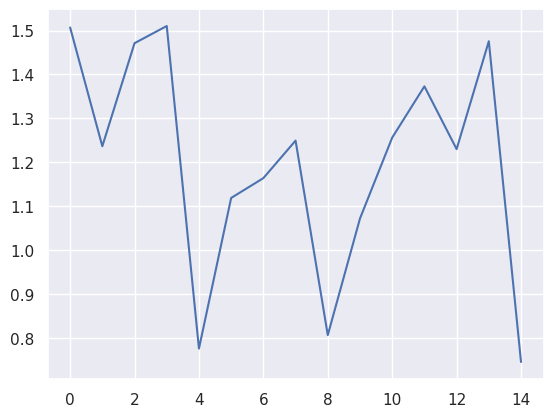

In [211]:
last_right_principal_vectors = []
for q in range(1_000 , 
               x_train.shape[0] , 
               1_000):
    residuals_reshaped, ed_errors, encode_decode_maps = pca.train(x_train[:q])
    last_right_principal_vectors.append( pca.vs[0][:,-1])
    

angles = [ np.min([np.arccos(np.matmul(vector.T,last_right_principal_vector)),
                np.arccos(np.matmul(vector.T, - last_right_principal_vector)) ])for vector in last_right_principal_vectors]

plt.plot(angles)
plt.show();

The direction of the last principal vector is settling down to the direction determined by having 16,000 samples. 

In [144]:
residuals_reshaped.shape

(16000, 20, 3)

In [169]:
pca_train_loss = ed_errors.mean()/20
pca_train_loss, 0.096687

(0.10311449907328027, 0.096687)

In [146]:
encode_decode_maps[0].shape

(20, 20)

# TEST DATASET: Build out Dataset for testing on one pod

In [63]:
# testing_df = pod_df[~pod_df['pod_id'].isin(upods)]

# testing_df.head()
# ## drop the pod_id
# test_df = test_df.drop("pod_id",1, inplace=False)


# ##set timestamp as the index
# test_df = test_df.set_index('Timestamp')

# ##normalize test_df 
# test_df = scaler.fit_transform(test_df.values)


# ##ensure the data is sorted!!
# test_df = test_df.sort_index()

### Then we test

In [25]:
# predictions = []
# anomaly_scores = []

# for i in range(0,len(test_df),12*5):
#     if(i + 12*5 < len(test_df)):
#         sample_topredict_on = test_df.iloc[i:i+12*5]
# #         display(sample_topredict_on)
#         x_test = np.array(sample_topredict_on['pod_cpu_utilization'].tolist())
#         x_test = x_test.reshape(1,-1,1)
#         preds,anom_scores = model.testnew(x_test)
#         predictions.append(preds)
#         anomaly_scores.append(anom_scores)




predictions = []
anomaly_scores = []
errors = []
for i in range(0,len(test_df),timesteps):
    if(i + timesteps < len(test_df)):
        sample_topredict_on = test_df.iloc[i:i+timesteps]
#         display(sample_topredict_on)
        x_test = np.array(sample_topredict_on['pod_cpu_utilization'].tolist())
        x_test = x_test.reshape(1,-1,1)
        preds,errs,anom_scores = model.test(x_test)
        predictions.append(preds)
        errors.append(errs)
        anomaly_scores.append(anom_scores)

1/1 [==============================] - 0s 21ms/step


In [26]:
anomaly_scores = np.concatenate(np.concatenate(anomaly_scores,axis=0),axis=0)
errors = np.concatenate(np.concatenate(errors,axis=0),axis=0)
predictions = np.concatenate(np.concatenate(predictions,axis=0),axis=0)

df_results = test_df.iloc[0:len(anomaly_scores)]
df_results['predictions'] = predictions
df_results['error'] = errors
df_results['anom_score'] = anomaly_scores

def anom_threshold_function(x):
    if(x > 0.8): return True
    else: return False

df_results['is_anomaly'] = df_results['anom_score'].apply(anom_threshold_function)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

/root/eks-ml-pipeline/modeling/autoencoder_model_dish_5g.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[ANOMALIES_COLUMN] = results_df[ANOMALIES_COLUMN].fillna(False)


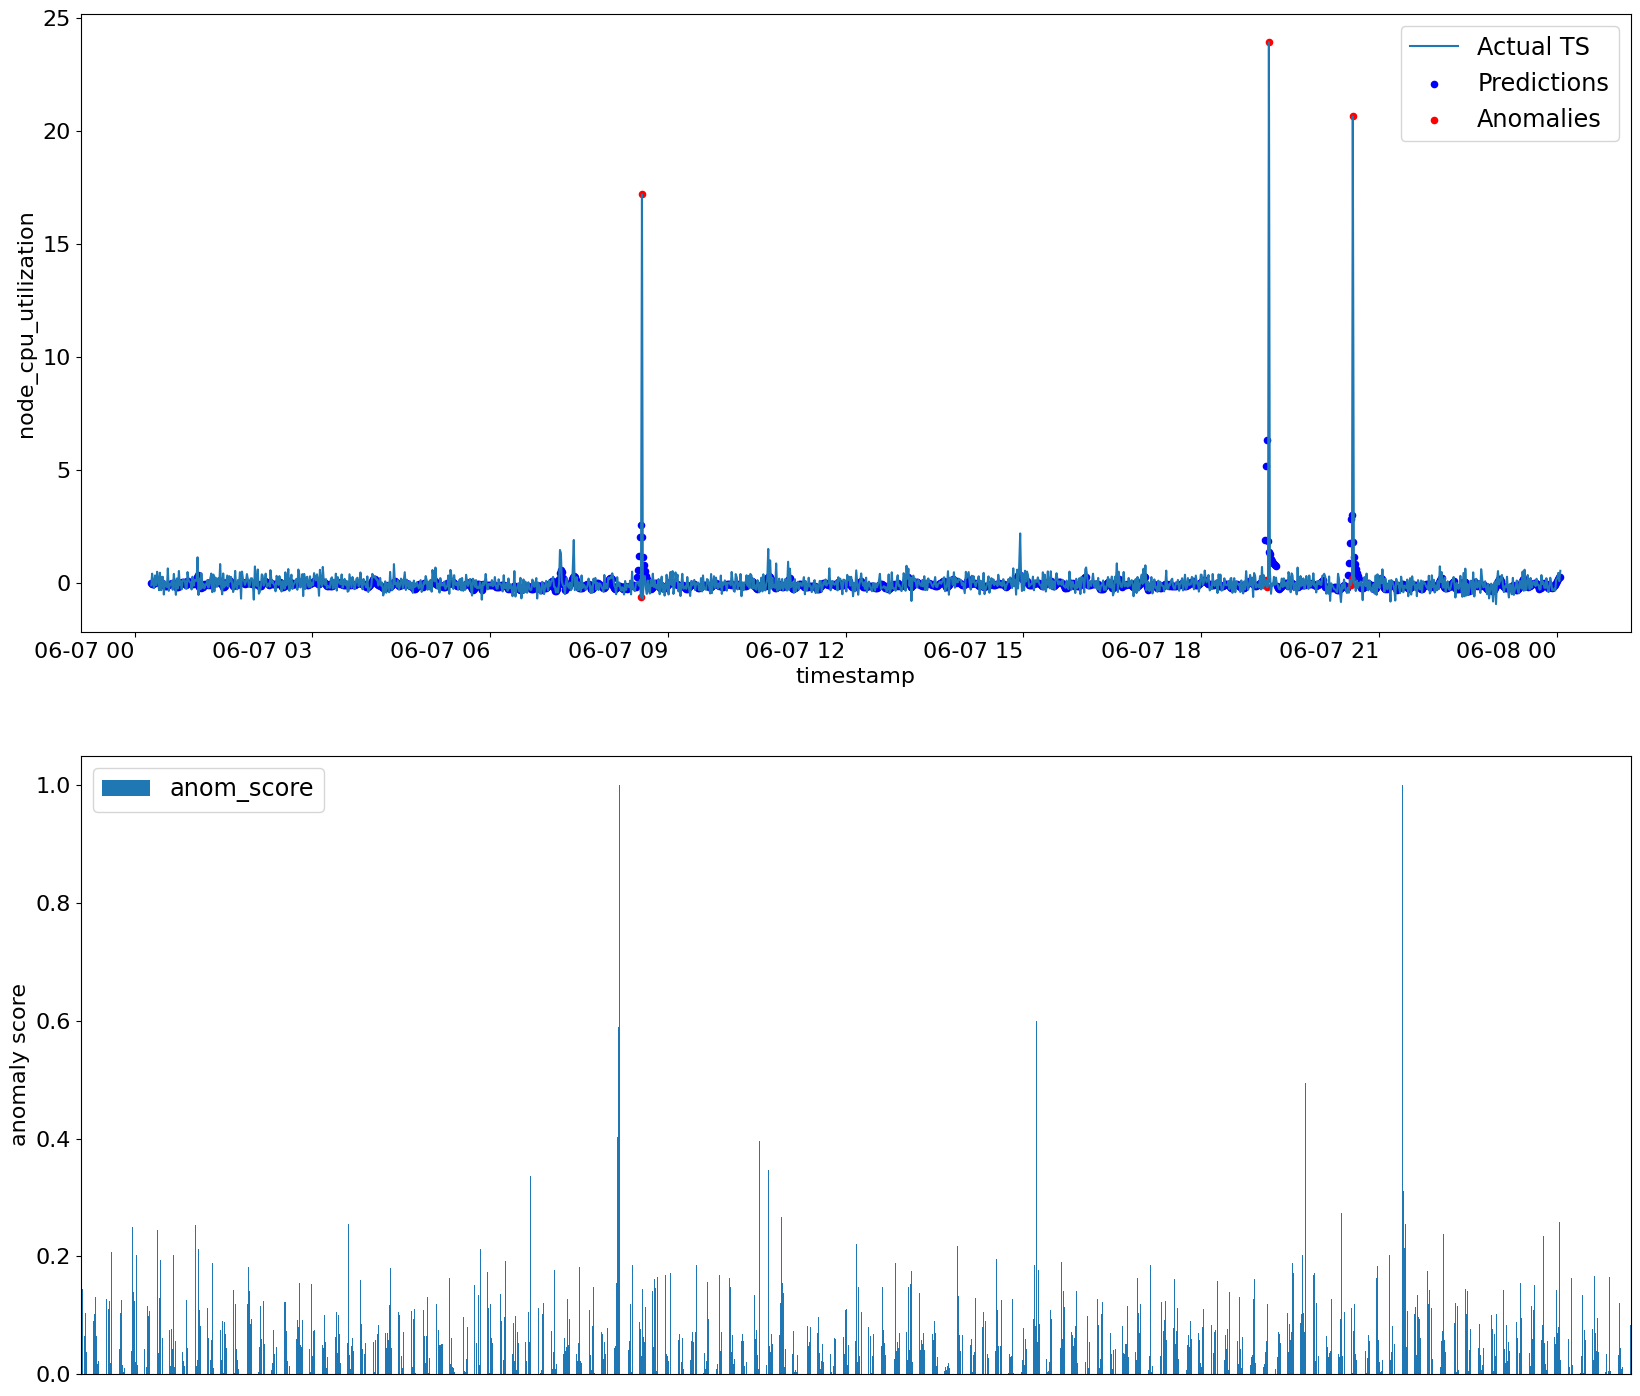

In [28]:

model.visualize(df_results, "pod_cpu_utilization")
plt.show()

In [ ]:
model.visualize(df_results, "pod_memory_utilization")
plt.show()

In [ ]:
model.visualize(df_results, "pod_memory_utilization")
plt.show()

In [ ]:
model.visualize(df_results, "pod_network_total_bytes")
plt.show()